<a href="https://colab.research.google.com/github/pushyag1/DeepLearningClass/blob/master/Chapter_3_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm


from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/My Drive/MPDL Fall 2020/')

from mpdl import train_simple_network, set_seed

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from mpdl import train_simple_network

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(42)

Convolutional Neural Networks (CNNs) revitalized the field of neural networks while simultaneously ushering in a new branding of "deep learning" starting in 2011 and 2012. CNNs are still at the heart of many of the most successful applications of deep learning, including self-driving cars, speech recognition systems used by smart devices, and optical-character-recognition. All of this stems from the fact that _convolutions_ are powerful yet simple tools that help us encode information about the problem into the design of our network architecture. Instead of focusing on feature engineering, we spend more time engineering the _architectures_ of our networks. 

The success of Convolutions comes from their ability to learn spatial patterns, which has made them the default method to use for any data resembling an image. When you apply a convolution to an image, you can learn to detect simple patterns like horizontal or vertical lines, changes in color, or grid-patterns. By stacking convolutions in layers, they begin to build up more complex patterns built from the simpler convolutions that came before. 

Our goal in this chapter is to reach you all the basics so that you can build your own CNNs for new image classification problems. First we need to discuss how images are represented to a neural network. That images are 2D is an important "structure" or meaning we are going to encode into the specific way we organize data in our tensors. You should always care about the structure of your data, because picking the right architecture that matches the structure is the best way to improve the accuracy of your model. Next we want to remove the mystery of what a convolution is, and show how convolutions can detect simple patterns and why its a good approach to use for data that is structured like an image. Next we will take a convolution and create a "convolutional layer", which can act as a replacement to a `nn.Linear` layer we used in the previous chapter. Finally, we will start to build some CNNs and discuss a few additional tricks to improve their accuracy. 

# Spatial Structural Prior Beliefs 

As of now, you know how to build and train a very simple kind of neural network. What you have learned is applicable to any kind of tabular (also called "columnar") data, where your data and features could be organized in a spreadsheet. However, other algorithms (e.g., Random Forests and XGBoost) are usually better for such data. If all you have is columnar data, you probably do not want to be using a neural network at all. 

When neural networks get really useful, and start to out-perform other methods, is when we use them to impose some kind of *prior belief*. We use the words "prior belief" in a very literal way, there is something we _believe_ is true about how the data/problem/world works, _prior_ to having ever looked at the data (If you have any friends who call themselves Bayesian, they might take offense at this definition - but thats _OK_. We are not being Bayesians today! Bayesian statistics often involves a more precise definition of a prior, see [here](http://www.stat.cmu.edu/~brian/463-663/week09/Chapter%2003.pdf) for an introduction.). Specifically, deep learning has been most successful at imposing *structural* priors. This is where, by how we design the network, we impart some knowledge about the intrinsic nature or "structure" of the data. The most common types of structure encoded into neural networks are spatial correlation (i.e., images in this chapter!) and sequential relationships (e.g., weather changes from one day to the next). 

There are a number of ways to do this, and the list is growing all the time. For now we will talk about what are known as _Convolutional Neural Networks_ (CNNs). These have dominated the image-based world.The first thing we need to learn is how an image and it's structure is encoded in PyTorch as tensors, so that we can understand how a convolution can use this structure. Previously we had input with no structure. Our data could be represented by an $(N, D)$ matrix, with $N$ data points and $D$ features. We could have re-arranged the order features, and it would not have changed the meaning behind the data, because there is no structure / importance to how the data is organized. All that matters is that if column $j$ corresponds to a specific feature, we always put that features value in column $j$ (i.e., we just need to be consistent). 

Images, however, are structured. There is an order to the pixels. If you shuffled the pixels around, you would fundamentally change the meaning of a picture. In fact, you would probably end up with an incomprehensible "image" if you did that. So if we have an image, it has a height $H$, and a width $W$. As a starting point, we might consider a "matrix" of image data to have shape 

$$(N, W, H)$$

This gives us a three dimensional tensor. This would be fine if we had black-and-white images only. But what about color? To fix this we need to add some _channels_ to our representation. Every channel has the same width and height, but represents a different perceptual concept. Color us usually represented with a Red, Green, and Blue *channel*, and we interpret the mixture of red, green, and blue to create a final color image. So if we want to include that, we need to have an additional dimension to the tensor for the channels. This becomes

$$(N, C, W, H)$$

Now we have a four dimensional tensor, and there is structure to the tensor. By structure we mean that the axes of the tensor, and the order we access data in, has a specific meaning. If `x` was a batch of color images `x[3,2,0,0]` is saying "from the 4th image $(N=3)$ grab the blue value $(C=2)$ of the upper left pixel $(0,0)$. Or we could grab the red, green, and blue values using `x[3,:,0,0]`. This means we we are processing the pixel values at locations $i$ and $j$, we know we need to access the index `x[:,:,i,j]`. More important, we need to know something about the _neighboring pixel to the bottom right_, we can access this value using `x[:,:,i+1,j+1]`. Thanks to the input being _structured_, this is true regardless of the values of $i$ and $j$. Convolutions will use this so that when a convolution is looking at pixel location $i, j$ in an image, it can also consider the neighboring pixel locations. 

The Red, Green, Blue channels are the most common standard for images and denoted with the short hand "RGB", but they are not the only option. These are often called "color spaces".  Another popular way to represent data is using Hue, Saturation, and Value (HSV) and the Cyan, Magenta, Yellow, and Key (read, black) (CMYK) color space. 

## Loading MNIST with PyTorch

While it has become a bit cliché, we will start exploring what all of this means using the ubiquitous MNIST dataset. Its a collection of black and white images of the digits 0 through 9, each is 28 pixels wide and 28 pixels tall. PyTorch has a convenient loader for this dataset in a package called `torchvision`, which we will load below. If you are doing _anything_ with images and PyTorch, you almost certainly want to be using this package. 

In [ ]:
import torchvision 
from torchvision import transforms

Now we can load the MNIST dataset using the below code. The first argument, `"./data"`, is just telling PyTorch where we would like the data stored, and `download=True` to download the dataset if its not already there. MNIST has a pre-defined training and testing split, which we can obtain by setting the `train` flag to `True` or `False` respectively. 

In [ ]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True)
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True)
x_example, y_example = mnist_data_train[0]
type(x_example)

PIL.Image.Image

Now you will notice that the `type` of the data returned was _not_ a tensor. We got a `PIL.Image.Image` (  https://pillow.readthedocs.io/en/stable/ ), because the dataset _is_ images! We need to use a `transform` to convert the images to tensors, which is why we have imported the `transforms` package from `torchvision`. We can simply specify the `ToTensor` transform, which converts a PIL image into a PyTorch tensor where the minimum possible value is 0.0, and the max is 1.0, so its already in a pretty good numerical range for us to work with. Lets redefine these dataset objects to do that right now. All it takes is adding `transform=transforms.ToTensor()` to the method call, as shown below where we load the train/test splits and print the shape of the first example of the training set. 

In [ ]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
x_example, y_example = mnist_data_train[0]
print(x_example.shape)

torch.Size([1, 28, 28])


We have accessed a single example from the dataset, and it has a shape of $(1, 28, 28)$ for $C=1$ channels (its black and white), and a width and height of 28 pixels. If we want to visualize a tensor representation of an image that is gray scale, `imshow` expects it to have only a width and height (i.e, a shape of $(W, H)$). The `imshow` function also needs us to tell it explicitly to use  gray scale. Why? Because `imshow` is meant for a wider class of scientific visualization, where you might not want other options instead.  

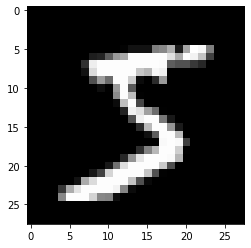

In [ ]:
imshow(x_example[0,:], cmap='gray')

Ok, clearly that was the digit "5"! Since we are learning how images are presented as tensors, lets go ahead and do a color version. If we just stack three copies of the same digit on top of each other, we will then have a tensor of shape $(3, 28, 28)$. Because the _structure_ of the tensor has meaning, this instantaneously makes it a color image by virtue of having 3 channels. The code below does exactly that, stacking the first grayscale image three times and printing its shape. 

In [ ]:
x_as_color = torch.stack([x_example[0,:], x_example[0,:], x_example[0,:]], dim=0)
print(x_as_color.shape)

torch.Size([3, 28, 28])


Now lets visualize the color version. Here we need to be a little careful. In PyTorch, an image is represented as $(N, C, W, H)$. But `imshow` expects a single image as $(W, H, C)$. So we will need to _permute_ the dimensions when using `imshow`. If we have $r$ dimensions to our tensor, the `permute` function takes $r$ inputs, the indexes $0, 1, \ldots, r-1$ of the original tensor in the _new order_ we want them to appear. Since our image has $(C, W, H)$ right now, maintaing that order would be $(0, 1, 2)$. We want the channel at index 0 to become the last dimension, width the first, and height second, so that would be $(1, 2, 0)$. Lets try it out. 

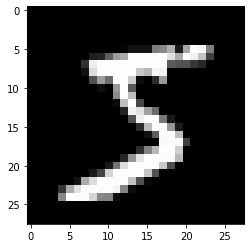

In [ ]:
imshow(x_as_color.permute(1,2,0))

Why was the above _color_ image still black and white? Because the original image was black and white! We have the exact same value copied in the red, green, and blue channels, which is how you represent a black and white image in color. If we zero out the red and blue channels, we would get a green number. 

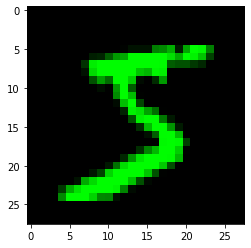

In [ ]:
x_as_color = torch.stack([x_example[0,:], x_example[0,:], x_example[0,:]])
x_as_color[0,:] = 0 #No Red
#Leaving green alone! 
x_as_color[2,:] = 0 #No Blue
imshow(x_as_color.permute(1,2,0))

Changing the color of the image above is an example of:

1. How the different channels impact what the data represents
2. What it means for this to be a _structured_ data representation. 

Just to make sure these two points are clear, lets stack three different images together into one color image. We will reuse the same 5 as the first image in the stack. That means it will go into the red channel, so we should see a red 5, mixed with two other digits that are green and blue respectively. 

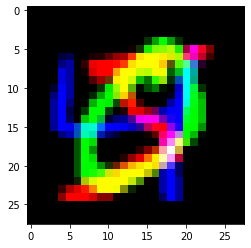

In [ ]:
#grab 3 images
x1, x2, x3 = mnist_data_train[0], mnist_data_train[1], mnist_data_train[2]
#drop the labels
x1, x2, x3 = x1[0], x2[0], x3[0]
x_as_color = torch.stack([x1[0,:], x2[0,:], x3[0,:]], dim=0)
imshow(x_as_color.permute(1,2,0))

You should see a red 5, a green 0, and a blue 4. Where two of the images overlap, because they were placed in separate color channels, you will see the colors blend. For example in the middle the 4 and 5 intersect, and red + blue = purple. 

The order of the data has meaning, and we can't simply arbitrarily re-order things without potentially destroying the structure, and thus, the data. Lets look at this more explicitly. What would happen if we were to shuffle the data within a channel? Does it have the same important structured meaning? Lets look at the digit 5 one last time, but instead we will randomly shuffle the values inside the tensor. 

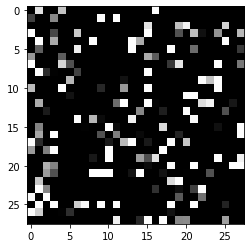

In [ ]:
rand_order = torch.randperm(x_example.shape[1] * x_example.shape[2])
x_shuffled = x_example.view(-1)[rand_order].view(x_example.shape)
imshow(x_shuffled[0,:], cmap='gray')

As you can see, this has _completely_ changed the meaning of the image! Instead of being a 5 its... nothing really. The location of a value, and it's _near by values_  is intrinsically part of that value's meaning. The value of one pixel cant not be separated from its' neighbors. This is the _structural spatial prior_ we are going to try and capture in this chapter. Now that we have learned how to represent the structure of images with tensors, we can learn about convolutions to exploit that structure. 

# What are Convolutions?

So what do we change now that we have our data shaped like an image? There is a _prior_ we would like to put into our model, which is that there is some kind of *spatial relationship* going on. The prior that convolutions encode is that _things near each other are related to each other, and far away things have no relationship_. Think about the pictures of the digit 5  above. Pick any black pixel. Most of its neighboring pixels are also black. Pick any white pixel, most of its neighbors are white or a shade of white. This is a kind of spatial correlation. It doesn't really matter where in the image this happens, because it tends to happen _everywhere_ by the nature of _being an image_. 

A convolution is a mathematical function with two inputs. Convolutions take an *input* image, and a *filter* (alo called a _kernel_) and output a new image. The gaol is that the filter will be able to recognize certain patterns from the input, and highlight them in the output. The below diagram illustrates this idea.  A convolution can be used to impose a spatial prior on any tensor with $r$ dimensions. 

![Example of a convolution. Some input image and a "filter" are combined by the convolution. The output is a new image that has been altered. The purpose of the filter is to identify / recognize certain patterns within the input. In this example, its identifying the horizontal line on top of a "7".](https://drive.google.com/uc?export=view&id=13VtNty-Awy6Op4Qq7Kk3Rz3_PEFvcFHg)



While we keep saying "images", convolutions are not constrained to working on only two dimensional data. To help us understand how convolutions work, we will start with a one dimensional example, because it makes the math easier to walk through together. Once we understand 1D convolutions, the 2D version we will use for images follows very quickly. Because we want to create multiple layers of convolutions, we will also learn about _padding_ which is necessary for that goal. Finally, we will talk about another way to think about convolutions called _weight sharing_. This is a different way of thinking about convolutions that will re-emerge throughout the book (like in the next chapter!). 


## 1D Convolutions

Lets talk about a one-dimensional "image" first. This would have a shape of $(C, W)$, for the number of channels and the width. There is no height right now because we are talking about just 1D, not 2D. For a 1D input with $(C, W)$ shape, we can define a filter with a shape of $(C, K)$. We get to choose the value of $K$, and we need $C$ to match up between the image and the filter. Since the number of channels must _always_ match, we would call this a "filter of size $K$" for short.  If we apply a filter of size $K$ to an input of shape $(C, W)$ we get an output that has shape $(C, W-2\cdot \lfloor K/2 \rfloor)$ Lets look at how that works the example below. 

![A 1D input "1, 0, 2, -1, 1, 2" is convolved with the filter "1, 0, -1". This means we take every sub-sequence of three input items, and multiple them with the filter values, and then add the results together. ](https://drive.google.com/uc?export=view&id=1W3qjKjyOrsaRKE9fGzwuKlvz2l78j0Ml)

An input of shape $(1, 6)$ is on the left and we are applying a filter of size 3 that has the values $[1, 0, -1]$. The output is on the right. For each output, you can see arrows coming in for the _spatially relevant_ inputs for that output. So the first output of $1$ only the first three inputs are relevant, nothing else in the input impacts that specific output. It's value is calculated by multiplying the first three inputs with the three values in the kernel, and then summing them together. The second value of the output is computed by using the second set of three input values. You will notice it is _always_ the same three values from the filter, applied to _every_ position in the input. 

In effect, we are _sliding_ the filter across every location in the input, computing a value at each location, and storing it in the output. Thats what a convolution is! The size of the output shrinks by $2\cdot \lfloor 3/2 \rfloor$ because we run out of values at the edges of the input. Next well show how to make this work in 2D, and then we'll have the foundation of CNNs!

## 2D Convolutions 

As we increase the number of dimensions $r$ that our tensor has, the idea of convolutions and how they work stays the same: we will slide a filter around the input, multiplying the values in the filter with each area of the image, and then take the sum. We simply make the filter shape match accordingly. Lets look at a 2D example now, which aligns with the images we are going to try and process. Thats shown in the below image, where the $\circledast$ operator is introduced to mean "convolve". 

![An image of a "1" convolved with a 2d filter. The green region shows the part of the image being currently convolved, with the values from the filter shown in light blue. The result in the output is shown in orange. By sliding the green/orange areas together over the entire image, you produce the output result.](https://drive.google.com/uc?export=view&id=1a34A8Foaw__elXzGk6bQSNppjbLniRJM)


Again, the 2D output is a result of multiplying the filter values (pair-wise) at each location, and summing them all together. The highlighted regions of the input are used to create the values in the output. In the bottom right corner of the input cells, you see the filter value we are multiplying by. In deep learning we almost always use "square" filters, meaning all $r$ dimensions of the filter have the exact same number of values. So in this case we would call this a 2D filter of size $K$, or just "size $K$" for short. In this case, $K=3$. 

Since this 2D input had a shape of $(1, 6, 6)$ and or kernel has a shape of $(1, 3, 3)$, we shrink the width and height by $2 \cdot \lfloor 3/2 \rfloor = 2$. So that means the height will be 6 pixels $-2 = 4$ pixels, and we get the same result for the width with $6-2=4$ pixels wide. We now have the exact operation that is the foundation of CNNs for image classification! 

## Padding

You will notice that right now, every time we apply a convolution the output becomes skinner and shorter than the original input. That means if we kept applying convolutions over and over again, we would eventually be left with nothing! This is not something we usually want, because we are going to create multiple layers of convolutions. Most modern deep learning design practices involve keeping the input and output the same size so that we can more easily reason about what shapes of our network and so that we can make them as deep as we would like, without worrying about the input disappearing to nothing! The solution to this is called _padding_. You should almost always use padding by default so that you can make changes to your architecture without having to concern yourself with changes in the shapes of your tensors. The below example shows how this works for the same 2D image. 

![The same convolution as before with the same input and filter, but the input is "padded" with the value "0" to make the image larger by one pixel in each direction. This causes the output image to become the same width and height as the original image.](https://drive.google.com/uc?export=view&id=11jRnDYx05sABcdR5HwQuvBqY6iLNxC3e)


We add an "imaginary" row/column of zeros all the way around the image, and process it as if it was larger than it actually is! This specific example would be called "zero padding by one", because we added one value to all the edges of the image, and the value was filled with "0". If we use a convolutional filter of size $K$, we can use padding of $\lfloor K/2\rfloor$ to make sure our output stays the same size as our input. Again, even though there is a height and width that could be padded to different degrees, we generally use the same amount of padding in each dimension because our filters have the same size in each dimensions. 

## Weight Sharing

There is another way to think about convolutions, which introduces an important concept called _weight sharing_. Lets look at the 1D case again just because it is simpler to write code for. Imagine you had a neural network $f_\Theta(\cdot)$ with parameters (or _weights_) $\Theta$, which takes in an input vector $\boldsymbol{z}$ with $K$ features, $\boldsymbol{z} \in \mathbb{R}^K$. Now lets say we have a larger input $\boldsymbol{x}$ with $C=1$ channels and $D$ features, where $D > K$.  We can not use $f_\Theta(\cdot)$ on $\boldsymbol{x}$ because the shapes $D \neq K$ do not match. 

One way we could apply the network $f_\Theta(\cdot)$ to this larger dataset would be to _slide_ the network across slices of the input, and _share_ the weights $\Theta$ for each position. Some python pseudo-code would like like this:
```python
x = torch.rand(D)#some input vector
output = torch.zeros(D-K//2*2)
for i in range(output.shape[0]):
    output[i] = f(x[i:i+K], theta)
```

Now, if we fined our network as `f = nn.Linear(K, 1)`, this would actually implement _exactly a 1D convolution_. This insight can teach us some important properties about convolutions and how we will use them in the design of deep neural networks. Right now, the primary think this teaches us is that _convolutions are linear operations, that work spatially_.  Like the `nn.Linear` layer from last chapter, this means a convolution followed by a second convolution is equivalent to doing just one, slightly different, convolution. That means:

1. Never repeat convolutions, because it is redundant. 
2. We need to include a non-linear activation function after we use convolutions. 


If we had a rectangular kernel of size $(1, 3, 5)$, the width of the output image would be  $2\cdot \lfloor 3/2 \rfloor = 2$ smaller than the input. The height of the output would become $2\cdot \lfloor 5/2 \rfloor = 4$, removing _two_ from each side! While rectangular kernels are possible, they are rarely used. You will also notice that we have been sticking with kernels that have an _odd_ size, nothing divisible by two. This is mostly a choice out of representational convenience, because it means there is an exact "center" that the filter is looking at from the input to produce each output. Again, filters with even sizes are possible, but rarely used. 

# Utility of Convolutions

At this point we have spent a lot of time talking about what convolutions are. Now its time to start seeing what convolutions can do! Before adding them to a neural network, convolutions have had a rich history of use in computer vision applications on their own. It turns out this simple operation alone can define many useful things, so long as we select the appropriate kernel. 

To start, lets again look at a _specific_ image of the digit 4 from MNIST. We will load the scipy `convolve` function for use, and define the `img_index` so that you can change what image we are processing and see how these convolutions work across other inputs too. 

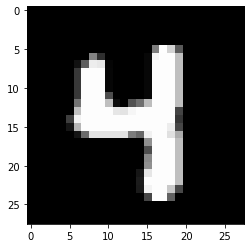

In [ ]:
from scipy.signal import convolve
img_indx = 58
img = mnist_data_train[img_indx][0][0,:]
plt.imshow(img, vmin=0, vmax=1, cmap='gray')

One common computer vision operation is to _blur_ an image. Blurring involves taking a local average pixel value and replacing every pixel with the average of its neighbors. This can be useful to wash out small noisy artifacts or. to soften a sharp edge. This can be done with a _blur kernel_ where:

$$\text{Image} \quad \circledast \frac{1}{9}\begin{bmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{bmatrix} = \text{Blurred Image}$$

We can take this math and convert it directly into code. The matrix will be an `np.asarray` call, we've already loaded the image, and the convolution $\circledast$ is done with the `convolve` function. Then when we show the output image, we get a blurry version of the digit "4". 

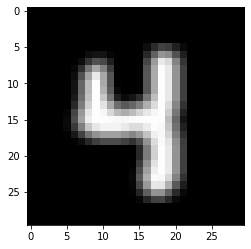

In [ ]:
blur_filter = np.asarray([[1,1,1],
                          [1,1,1],
                          [1,1,1]
                         ])/9.0

blurry_img = convolve(img, blur_filter)
plt.imshow(blurry_img, vmin=0, vmax=1, cmap='gray')
plt.show()

An especially common application of convolutions is to perform _edge detection_. In any computer vision application, its always good to know where the edges are! Edges can help you determine where the edges of a road are (you want your car to stay in its lane!) or find objects (edges in different shapes are easy to recognize).  In the case of this "4", that would be the outline of the digit. So if everything in a local area of the image is the _same_ we want everything to cancel out and result in no output. We only want there to be an output when there is a local change. Again, this can be described as a kernel where everything around the current pixel is negative, and the center pixel counts for the same weight as all its neighbors. 

$$\text{Image} \quad \circledast \begin{bmatrix}
-1 & -1 & -1\\
-1 & 8  & -1\\
-1 & -1 & -1
\end{bmatrix} = \text{Edge Image}$$

This filter is maximized when everything around a pixel is different than itself. Lets see what happens. 

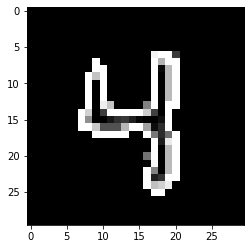

In [ ]:
#We can find edges by focusing on the difference between a pixel, and its neighbors
edge_filter = np.asarray([[-1,-1,-1],
                          [-1, 8,-1],
                          [-1,-1,-1]
                         ])


edge_img = convolve(img, edge_filter)
plt.imshow(edge_img, vmin=0, vmax=1, cmap='gray')
plt.show()

As promised, it found the edges of the digit! The response only occurs at the edges because thats where the most changes are. Outside the digit there is no response because the high center weight cancels out all the neighbors, which is also true for the _inside_ region of the digit. Thus, we have now found all the edges inside the image. 

We also may want to look for images at a _specific_ angle. If we constrain ourselves to a $3\times 3$ kernel, it is easiest to find horizontal or vertical edges. Lets make one for horizontal edges by making everything the kernel values change signs across the horizontal of the filter. 

$$\text{Image} \quad \circledast \begin{bmatrix}
-1 & -1 & -1\\
 0 & 0  &  0\\
 1 &  1 &  1
\end{bmatrix} = \text{Horizontal Edge Image}$$

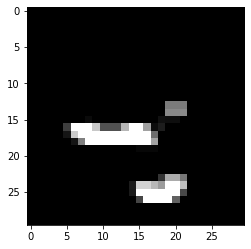

In [ ]:
#We could look for only horizontal edges
h_edge_filter = np.asarray([[-1,-1,-1],
                          [0, 0,0],
                          [1, 1, 1]
                         ])


h_edge_img = convolve(img, h_edge_filter)
plt.imshow(h_edge_img, vmin=0, vmax=1, cmap='gray')
plt.show()

Now we see that we identified only the horizontal edges of the image, which is primarily the bottom bar of the 4. As we define more useful kernels, you can start to imagine how we might compose a _combination_ of filters to start recognizing higher level concepts. Imagine we we only had the vertical and horizontal filters, we would not be able to classify all 10 digits, but the below diagram shows how we could narrow down the answer! 

![Example where we only have a vertical and horizontal edge filter. If only the vertical filter turns on, we are probably looking at the digit "1". If only the horizontal filter turns on, we could be looking at a "7", but we would really like an additional "diagonal" filter to help us confirm. If both the horizontal and vertical filters respond, we could be looking at a "4" or a "9", its hard to tell without more filters. ](https://drive.google.com/uc?export=view&id=1rT5DowWcyOv1_J1yLLX42zeYnEJ1bKbV)


Designing all the filters you might need by hand was a big part of computer vision for many decades. You could even start to think about how convolutions on top of convolutions could start to learn larger concepts. For example, after identifying horizontal and vertical edges, a new filter might take those as input and look for a an empty space in the center with horizontal edges on top and vertical edges on the side. This would get us the "O" like shape to tell the difference between a "9" and a "4". 

Thanks to deep learning though, we don't have to go through all the mental effort of trying to imagine and test all the filters we might need. Instead, we can let the neural network learn the filters itself! That way we save ourselves from a labor intensive process, and the kernels are optimized for the specific problem we care about!

# Putting it to Practice, our first CNN

Now we have discussed what a convolution is, lets bring it back to some mathematical symbols and PyTorch code! We've seen that we can take an image $I \in \mathbb{R}^{C, W, H}$ and apply a convolution using a filter $g  \in R^{C, K, K}$, to get a new result image $\mathbb{R}^{W', H'}$. If we are writing this out in math, we would write it as :

$$
R = I \underbrace{\circledast}_{\text{"Convolve"}} g
$$

That means each filter is going to look at all $C$ input channels on its own. Lets take a look at that using the 1D input example since it is easier to visualize. 

![](https://drive.google.com/uc?export=view&id=15ICJacsOpZOLUCjuDAU-257HxaxHA1XS)


Because the input has a shape of $(C, W)$, the filter has a shape of $(C, K)$. So when the input has multiple channels, the kernel will have a value for each channel separately. That means for a color image, we could have a filter that looks for "red horizontal lines, blue vertical lines, and no green" all in one operation. But it also means that after applying _one filter_ we get _one output_. 

Considering the examples above, we probably want more than just _one_ filter though.  We want to have $C_{\text{out}}$ different filters, and lets go ahead and use $C_{\text{in}}$ to indicate the number of channels in the input. In this case we would then have a tensor that represents all of the filters as $G \in \mathbb{R}^{C_{\text{out}}, C_{\text{in}}, K, K}$, so that we get a new result $R \in \mathbb{R}^{K, W', H'}$ when we write

$$
R = I \circledast G
$$

So how do we convert this math notation, that we are going to convolve some input image $I$ with a set of multiple filters $G$? PyTorch provides the `nn.Conv1d`, `nn.Conv2d`, and `nn.Conv3d` functions for handling all of this for us. Lets quickly diagram that out to understand what is happening as a mechanical process. 

![](https://drive.google.com/uc?export=view&id=1Vm2hGfYruicOFakCAQO0LssqOAYofLDP)


The input image comes in and has $C_\text{in}=3$ channels, and we are going to process it using `nn.Conv2d(C_in, C_out, 3, padding=3//2)(x) = output`. Since $C_\text{out}=2$, that means we process the input with two _different_ filters, add the bias terms for every location, and get two resulting images that have the same height and width as the original image (because we used padding). The results are stacked together into one larger single image with 2 channels because we specified $C_\text{out}=2$. 

Now, when we had a fully connected layer, we wrote something like 

$$f(\boldsymbol{x}) = \text{tanh}\left(\boldsymbol{x}^{\top} \boldsymbol{W}^{(h_1)}_{d \times n} + \boldsymbol{b^{(h_1)}}\right) \boldsymbol{W}^{(\text{out})}_{n \times \text{classes}} + \boldsymbol{b^{(out)}} $$ 

for a single hidden layer with $n$ hidden units/neurons. The mathematical notation we would use to describe a network with one _convolutional_ hidden layer is very similar:

$$
f(\boldsymbol{x}) = \text{tanh}\left(\underbrace{\boldsymbol{x}_{C_{\text{in}}, W, H} \circledast \boldsymbol{W}^{(h_1)}_{C_{\text{out}}, C_{\text{in}}, K, K}}_{\text{nn.Conv2d}(C_{\text{in}}, C_{\text{out}}, K)} + \boldsymbol{b^{(h_1)}}\right) \boldsymbol{W}^{(\text{out})}_{(C_{\text{out}} \cdot w \cdot h) , C}  +\boldsymbol{b^{(\text{out})}}
$$

That equation may look a little scary, but if we slow down its not that bad. Its "intimidating" because we have included the shape of each tensor in the equation, and annotated where our fancy new `nn.Conv2d` `module` comes into play. I've included the shape information so that you can see how we are processing different sized inputs, and some people like to follow that level of detail. If we remove all those extra details, its not as scary looking. 

$$
f(\boldsymbol{x}) = \text{tanh}\left(\boldsymbol{x} \circledast \boldsymbol{W}^{(h_1)} + \boldsymbol{b^{(h_1)}}\right) \boldsymbol{W}^{(\text{out})}  +\boldsymbol{b^{(\text{out})}}
$$

Now it looks much friendlier, and it becomes clear that the only thing we have actually changed is replacing the dot product (a liner operation denoted by "${}^\top$" ) with convolution (a spatially linear operation denoted by "${}\circledast$"). 

This is _almost_ perfect, but we have one issue. The output of the convolution has a shape of $(C, W, H)$ but our linear layer ($\boldsymbol{W}^{(\text{out})} +\boldsymbol{b^{(\text{out})}}$) expects something of shape $(C\times W \times H)$, thats _one_ dimension that has all the three original dimensions collapsed into it! Essentially, we need to _reshape_ the output of our convolutions to remove the spatial interpretation, so that our linear layer can process the result and compute some predictions. 

This is called _flattening_ , and is a common operation in modern deep learning. We can consider \ref{eq:conv_net_func_simple} to have implicitly used this flatten operation. PyTorch provides ` module` for doing this called `nn.Flatten`. 

Now lets finally define some code for training this CNN based model. First we need to grab the CUDA compute device, and create a `DataLoader` for the training and testing set. We will use a batch size $B$ of 32. 

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

B = 32
mnist_train_loader = DataLoader(mnist_data_train, batch_size=B, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=B)

Now we are going to define some variables. Again, because PyTorch works in batches if data, when we think in a PyTorch context our tensor shapes will begin with $B$, and since the input are images, the initial shape is $(B, C, W, H)$. We have $B=32$ because we defined that, and $C=1$ because MNIST is black and white. Well define a few helper variables like `K` to represent our filter size, and `filters` for how many filters we want to build. 

The first model we will is `model_linear`, because it uses only `nn.Linear` layers. It begins with calling `nn.Flatten()`. Notice the specific comment we put into the code `#(B, C, W, H) -> (B, C*W*H) = (B,D)`. This is to remind us that we are changing the shape of the tensor using this operation. The original shape $(B, C, W, H)$ is on the left, and the new shape $(B, C\times W \times H)$ is on the right. Since we have the variable $D$ to represent the total number of features, we also included a note on the value it is equal to `=(B,D)`. It is very easy to loose track of the shapes of tensors when writing code, and is one of the easiest ways to introduce bugs. I always try to include comments like this whenever the shape is altered by a tensor. 

In [ ]:
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images 
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10
#How many filters should we use
filters = 16
#how large should our filters be?
K = 3
#for comparison, lets define a linear model of similar complexity
model_linear = nn.Sequential(
  nn.Flatten(), #(B, C, W, H) -> (B, C*W*H) = (B,D)
  nn.Linear(D, 256), 
  nn.Tanh(),
  nn.Linear(256, classes),
)

#A simple convolutional network:
model_cnn = nn.Sequential(
  #Conv2d follows the pattern of:
  #Conv2d(# of input channels, #filters/output-channels, #filter-size)
  nn.Conv2d(C, filters, K, padding=K//2), #$x \circledast G$
  nn.Tanh(),#Activation functions work on any size tensor
  nn.Flatten(), #Convert from (B, C, W, H) ->(B, D). This way we can use a Linear layer after
  nn.Linear(filters*C*D, classes),
)

The `model_linear` is a simple fully connected layer for us to compare against. Our first Convoltuional Neural Network (CNN) is defined by `model_cnn`, where we use the `nn.Conv2d` module to input a convolution. Then we can apply our non-linear activation function $\tanh$ just like before. We only flatten the tensor once we are ready to use a `nn.Linear` layer to reduce the tensor to a set of predictions for each class. Thats why the `nn.Flatten()` module occurs right before the call to `nn.Linear` 

So does a CNN perform better? Lets find out! We can train both a CNN and a fully-connected model, measure accuracy on the test set, and look at the accuracy after each epoch. 

In [ ]:
loss_func = nn.CrossEntropyLoss()
cnn_results = train_simple_network(model_cnn, loss_func, mnist_train_loader, val_loader=mnist_test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)
fc_results = train_simple_network(model_linear, loss_func, mnist_train_loader, val_loader=mnist_test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

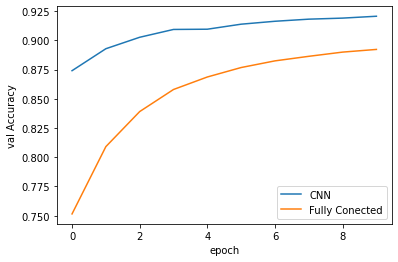

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results, label='CNN')
sns.lineplot(x='epoch', y='val Accuracy', data=fc_results, label='Fully Conected')

In [ ]:
print(round(cnn_results['total time'].values[-1]/fc_results['total time'].values[-1],3), " times slower")

1.088  times slower


One epoch of training out CNN has _better accuracy_ than our fully connected network ever achieves! While our CNN is slower to train, the results are well worth it. Why did it perform so much better? Because we have given the network information about the problem (convolutions) via the structure of the domain (data are images). This does not mean CNNs are always better. If the assumptions of a CNN are not true, or not accurate, they will not perform well. Remember that the prior belief convolutions impart is that things located near each other are related, but far apart things are not related. 

# Pooling And Object Location

Just like with our feed-forward networks, we can make our convolutional networks more powerful by stacking more and more layers with non-linearities inserted inbetween. But before we do that, there is a special type of layer we like to use with CNNs called a _pooling_ layer. 

Pooling helps us solve a problem, that we aren't fully exploiting the spatial nature of our data. That may seem a confusing statement. We just significantly increased our accuracy with a simple switch to `nn.Conv2d`, and we spent a lot of time talking about how convolutions encode this spatial prior, that they slide a set of weights over the input, applying them at every location. The problem is that we _eventually_ switch to using a fully connected layer, at which does not understand the spatial nature of the data. For this reason, the `nn.Linear` layer will learn to look for values at _very specific_ locations. 

This is not a huge problem for MNIST because all of the digits are aligned so that they are in the center of the image. But imagine you have a digit that is not perfectly center-aligned with your image. This is a very real potential problem! Pooling helps us solve this problem. Lets quickly grab an image from the MNIST dataset, and create two altered versions by just _ever so slightly_ moving the content up/down by one pixel. 

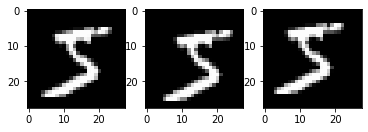

In [ ]:
img_indx = 0
img, correct_class = mnist_data_train[img_indx]
img = img[0,:]
#move to the lower right, then upper left
img_lr = np.roll(np.roll(img, 1, axis=1), 1, axis=0)
img_ul = np.roll(np.roll(img, -1, axis=1), -1, axis=0)
#plot the images
f, axarr = plt.subplots(1,3)
axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(img_lr, cmap='gray')
axarr[2].imshow(img_ul, cmap='gray')
plt.show()

Clearly, all three versions of the above image are the same digit. It does not matter that we shifted the content up or down, left or right, by just a few pixels. _But our model does not know this_! If we classify different versions of the above image, there is a good chance we get it wrong!

Lets quickly put this model into `eval()` mode, and write a quick function to get the predictions for a single image. That happens with the below `pred` function, that takes an image as input. 

In [ ]:
#eval mode since we are not training
model = model_cnn.cpu().eval()

def pred(model, img):
    with torch.no_grad():#Always turn off gradients when evaluating!
        w, h = img.shape#Whats the width/height of the image
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img)
        x = img.reshape(1,-1,w,h)#reshape it as (B, C, W, H)
        logits = model(x) #Get the logits
        y_hat = F.softmax(logits, dim=1)#Turn into probabilities 
        return y_hat.numpy().flatten()#convert prediction to numpy array. 

This is a simple way to apply a model to _single_ images at a time. PyTorch always expects things to be in batches, so we needed to reshape the input to have a batch dimension, which is equal to 1 since there are no other images at a time. The `if not isinstance` check is some defensive code you can add to make sure your code works for both NumPy and PyTorch input tensors. Also remember that the `CrossEntropy` loss we used handles softmax implicitly. So when we use a model trained with `CrossEntropy`, we need to call `F.softmax` ourselves to transform the outputs into probabilities. 

With that our of the way, we can get predictions for all three images to see if tiny changes to the image can have a big change on the network's prediction. Remember, each image  differs by shifting the image to the lower right or upper left by one pixel! So intuitively, we would expect very little to change. 

In [ ]:
img_pred = pred(model, img)
img_lr_pred = pred(model, img_lr)
img_ul_pred = pred(model, img_ul)

print("Org Img Class {} Prob:         ".format(correct_class) , img_pred[correct_class])
print("Lower Right Img Class {} Prob: ".format(correct_class) , img_lr_pred[correct_class])
print("Uper Left Img Class {} Prob:   ".format(correct_class) , img_ul_pred[correct_class])

Org Img Class 5 Prob:          0.71119416
Lower Right Img Class 5 Prob:  0.42959082
Uper Left Img Class 5 Prob:    0.20915362


In [ ]:
min_pred = round(min(img_pred[correct_class], img_ul_pred[correct_class], img_lr_pred[correct_class])*100,1) 
max_pred = round(max(img_pred[correct_class], img_ul_pred[correct_class], img_lr_pred[correct_class])*100,1) 
min_pred = str(min_pred) + "%"
max_pred = str(max_pred) + "%"

Clearly, we want all three of the above examples to receive the same classification. They are *essentially* the same image, yet the outputs swing from a reasonably confident and correct {{max_pred}} down to an erroneous {{min_pred}}! The problem is that a small shift or "translation" of causes the predictions to change significantly. 

What we desire is a property called  *translation invariance*. To be invariant to property X means that our output does not change based on changes to X. We do not want translations (shifting up/down) to change our decisions. So we want to be translation invariant.  

We can obtain some partial translation invariance with an operation known as *pooling*. Specifically, we will look at _max pooling_. What is max pooling? Similar to convolution, we will apply the same function to multiple locations in an image. We will generally stick to even sized pooling filters. As the name would imply, we slide the `max` function function around the image. You could again describe this as having a kernel size $K$, which is the size of the window to select the maximum from. 
The big difference here is that we move the `max` function by $K$ pixels at a time, where we did only 1 pixel at a time when performing a convolution. Lets see how that works with the below example. 

![Example of max pooling for $K=2$ (top) and $K=3$ (bottom). Each region of the input (left) has a color indicating the group of pixels participating in the pooling, and the output (right) shows which value was selected from the input region. Note that the output is smaller than the input by a factor of $K$.](https://drive.google.com/uc?export=view&id=15jJXJQ8Wf4plhgaVEKWijhMKD0q6hOvk)


The choice on how many pixels to "slide" by is called the _stride_. By default, practitioners tend to use `stride=1` for convolutions so that _every_ possible location is evaluated. We use `stride=K` for pooling so that the input is shrunk by a factor of $K$. For any operation, if you use a `stride=Z` for any (positive integer) value of $Z$, the result will be smaller by a factor of $Z$ along each dimension. 

The intuition behind pooling is that it gives us more robustness to slight changes in values. Consider the first image above, if your shifted every value over to the right by one position. Five of the nice output values _would not change_, giving it a minor degree of _invariance_ to _translating_ the image by one pixel. This is not perfect, but it helps reduce the impact of such alterations. If we accumulate this effect through multiple rounds of pooling, we can make the effect stronger. 

Just like before, PyTorch provides a `nn.MaxPool1d`, `nn.MaxPool2d`, and `nn.MaxPool3d`, for almost all your needs! It takes the kernel size as input, which is also the stride. Having a stride of $K$ means we shrink the size of each shape dimension by a factor of $K$. So if our input had a shape of $(B, C, W, H)$, the output of `nn.MaxPool2d(K)` will be a shape of $(B, C, W/K, H/K$). Since $C$ remains the same, that means We apply this simple operation to every channel independently. If we do max-pooling with a $2\times 2$ filter (the norm for most applications), we end up with an image 1/4 the size (half as many rows, and half as many columns)!

## CNNs with Max Pooling

Its easy to add pooling into our model's defintion. Just  insert `nn.MaxPool2d(2)` into the `nn.Sequential` and it will be in there. But _where_ exactly should we use max pooling? First, lets talk bout _how many times_ you should apply max pooling. Every time pooling is applied, we shrink the width (and height if 2d!) by a factor of $K$. That means $n$ rounds of pooling means shrinking by a factor or $K^n$, so that will make the image very small very quickly. For MNIST, we only have 28 pixels of width, so we can do at most 4 rounds of pooling with a size of $K=2$. Thats because 5 rounds would give us $28/2^5 = 28/32$, which is _less than a pixel of output_! 

So does 4 rounds of pooling make more sense? Try to imagine it was a problem _you_ were asked to solve. 4 rounds of pooling means shrinking the image to just $28/2^4=28/16=1.75$ pixels tall. If you could not hazard a guess at what digit was being represent with 1.75 pixels, your CNN probably can't either. Visually shrinking your data down is a good way to estimate the maximum amount of pooling you should apply to most problems. Using two-three rounds of pooling is a good initial lower bound / estimate for images up to $256 \times 256$ pixels. 

Most modern applications of CNNs are on images smaller than $256 \times 256$. Thats very large for us to process with modern GPUs and techniques. In practice if your images are larger than that, the first step is to re-size them to have at most 256 pixels along any dimension. If you really _need_ to be processing at a larger resolution, you probably want to have someone on your team with more detailed experience. As the tricks to working at that scale are more unique, and often require very expensive hardware. 

Every application of pooling is shrinking the image by a factor of $K$. This also means the network has less data to process after every round of pooling. If you are working with very large images, this can be used to help reduce the time it takes to train larger models, and reduce the memory costs of training. If neither of these are problems, common practice is to increase the number of  filters by $K\times$ after every round of pooling. This is so that the total amount of computation being done at every layer remains roughly the same (i.e., twice as many filters on half as many rows/columns about balances out). 

Lets quickly try this out on our MNIST data. The bellow code will define a deeper CNN with multiple layers of convolution, and two rounds of max pooling. 

In [ ]:
model_cnn_pool = nn.Sequential(
  nn.Conv2d(C, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Conv2d(filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.MaxPool2d(2),

  nn.Flatten(), 
  #Why did we reduce the number of units into the Linear layer by a factor of $4^2$? Because pooling a 2x2 grid down to one value means we go from 4 values, down to 1, and we did this two times!. 
  nn.Linear(2*filters*D//(4**2), classes),
)

cnn_results_with_pool = train_simple_network(model_cnn_pool, loss_func, mnist_train_loader, val_loader=mnist_test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

Now if we run the same shifted test image through our model, we should see some different results. Max pooling is not a _perfect_ solution to the translation problem, so the scores for each shifted version of the image still change. But they don't change _as much_. That is overall a good thing, because it makes our model more _robust_ to real life issues. Data will not always be perfectly aligned, so we want to help make the model resilient to the kinds of issues we expect to see in real life test data. 

In [ ]:
model = model_cnn_pool.cpu().eval()
img_pred = pred(model, img)
img_lr_pred = pred(model, img_lr)
img_ul_pred = pred(model, img_ul)

print("Org Img Class {} Prob:         ".format(correct_class) , img_pred[correct_class])
print("Lower Right Img Class {} Prob: ".format(correct_class) , img_lr_pred[correct_class])
print("Uper Left Img Class {} Prob:   ".format(correct_class) , img_ul_pred[correct_class])

Org Img Class 5 Prob:          0.5799873
Lower Right Img Class 5 Prob:  0.81186557
Uper Left Img Class 5 Prob:    0.4201325


Last, we can look at the accuracy of this new and larger network as we trained, which is shown in the below plot. Adding more layers is causing it to take _much_ longer for our network to converge, but once it does, it is able to eke out a little better in terms of accuracy. 

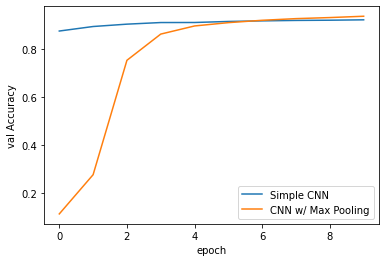

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results, label='Simple CNN')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results_with_pool, label='CNN w/ Max Pooling')

It is common for more layers to cause training to take longer to converge _and_ longer to process for each epoch. This double whammy is only offset by the fact that more layers, making the models _deeper_, is how we tend to obtain the best possible accuracy. If you continued to train this deeper model for more epochs, you will see it continue to climb a little higher than we could achieve with our first model containing only one `nn.Conv2d` layer. 

As we continue further into this book, we will learn about newer and better approaches that help resolve these issues. Making us converge faster and better. But I want to take you through this slower and somewhat more painful path, so that you understand _why_ these newer techniques were developed and what problems they are solving for us. This deeper understanding will help you be better prepared for the more advanced techniques we will then be able to tackle by the time you finish this book. 

# Data Augmentation 

It may seem a little anticlimactic, but you do now know everything you need to start training and building your own CNNs for new problems. Applying really was just replacing `nn.Linear` layers with `nn.Conv2d`, followed by a `nn.Flatten` just before the end. But there is one more big secret to applying CNNs in practice. Thats to use _data augmentation_. In general, neural networks are "data hungry", meaning that they learn best when you have a _huge_ amount of _diverse_ data. Since data takes time to get, we will instead _augmented_ our real data by creating new "fake" data based on our real data. 

The idea is simple. If we are working with 2D images, we can do a lot of transforms we could apply to an image that do not change the meaning of it's content, but do alter the pixels themselves. For example, we could rotate the image by a few degrees without really altering what the content means. PyTorch provides a number of transforms in the `torchvision.transforms` package, lets take a look at some of them. 

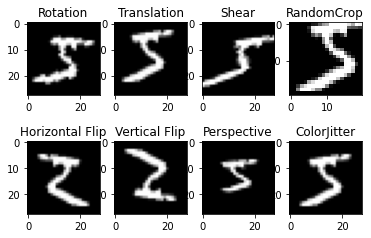

In [ ]:
#Several built-in transformations, given some agressive values to make their impact more obvious.  
sample_transforms = {
    "Rotation" : transforms.RandomAffine(degrees=45),
    "Translation" : transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    "Shear": transforms.RandomAffine(degrees=0, shear=45),
    "RandomCrop" : transforms.RandomCrop((20,20)),
    "Horizontal Flip" : transforms.RandomHorizontalFlip(p=1.0),
    "Vertical Flip": transforms.RandomVerticalFlip(p=1.0),
    "Perspective": transforms.RandomPerspective(p=1.0),   
    "ColorJitter" : transforms.ColorJitter(brightness=0.9, contrast=0.9)
}
#Convert the Tensor image back to a PIL image using a transform
pil_img = transforms.ToPILImage()(img)
#Plot a randomy application of each transform
f, axarr = plt.subplots(2,4)
for count, (name, t) in enumerate(sample_transforms.items()):
    row = count % 4
    col = count // 4
    axarr[col,row].imshow(t(pil_img), cmap='gray')
    axarr[col,row].set_title(name)
plt.show()

First thing you should notice is that transforms are almost always _randomized_, and every time we apply one it gives a different result. These new results are our augmented data! For example specifying the `degrees=45` is saying that the maximum rotation will be $\pm45^{\circ}$ degrees, and the amount applied will be a randomly chosen value in that range. This is done to increase the _diversity_ of inputs our model sees. Some transforms do not always apply themselves, and offer the `p` argument to control the probability they are chosen. We set these as `p=1.0` so that you would definitely see them have an impact on the test image. For real use, you probably want to pick a value of `p=0.5` or `p=0.15`. Like many things, the specific value you want to use will depend on your data. 

Not every transform should _always_ be used. You need to make sure that your transforms preserve the "essence" or "meaning" of your data. For example, we can clearly see that horizontal and vertical flips are not a good idea for the MNIST dataset. A vertical flip applied to the digit 9 could turn it into a 6, and that _changes the meaning of the image_. Your best bet to selecting a good set of transforms is to apply them to data and _look at the results yourself_, if you cant tell what the correct answer is anymore, chances are your CNN can't either! 

But once you select a set of transforms you are comfortable with, it is a simple and powerful approach to improved your model's accuracy. Below is a short example of how you can combine the `Compose` transform to create a sequence of transforms in a larger pipeline, which we can apply to augment our training data on the fly. All of the image based datasets PyTorch provides have the `transform` argument so that you can perform these alterations. 

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=15),
    transforms.ToTensor(),
])

test_transform = transforms.ToTensor()

mnist_train_t = torchvision.datasets.MNIST("./data", train=True, transform=train_transform)
mnist_test_t = torchvision.datasets.MNIST("./data", train=False, transform=test_transform)
mnist_train_loader_t = DataLoader(mnist_train_t, shuffle=True,  batch_size=B, num_workers=5)
mnist_test_loader_t = DataLoader(mnist_test_t, batch_size=B, num_workers=5)

A new and important optional argument has been specified in the `DataLoader` class. The `num_workers` flag controls how many threads are used to _pre-load_ batches of data for training. While the GPU is busy crunching on a batch of data, each thread can be preparing the next batch so that it is ready to go once the GPU is done. You should always be using this flag because it helps use your GPU more efficiently. Its especially important when you start using transforms, because they CPU will have to spend time processing the images which keeps your GPU idly waiting for longer. 

Now we can redefine the exact same network we used to show max pooling, and call the exact same training method. The data augmentation happens automatically for us by just defining these new data loaders. A simple `ToTensor` transform is all that we use for the test set, because we want the test set to be _deterministic_. That means if we run the same model five times on the test set, we get the same answer five times. 

In [ ]:
model_cnn_pool = nn.Sequential(
  nn.Conv2d(C, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Conv2d(filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Flatten(), 
  nn.Linear(2*filters*D//(4**2), classes),
)

cnn_results_with_pool_augmented = train_simple_network(model_cnn_pool, loss_func, mnist_train_loader_t, val_loader=mnist_test_loader_t, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

Now we can plot the result showing the difference of validation accuracy. With a careful choice of augmentation, we actually helped our model learn faster and converge to a better quality solution, 94% accuracy instead of 93%. 

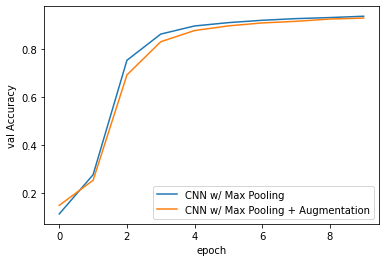

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results_with_pool, label='CNN w/ Max Pooling')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results_with_pool_augmented, label='CNN w/ Max Pooling + Augmentation')

Designing good data augmentation pipelines is the "feature engineering" counterpart to deep learning. If you do it well, it can have a massive impact on your results, and be the difference between success and failure. Because PyTorch uses PIL images as its foundation, you can also write your own custom transforms to add into the pipeline. This is where you can import other tools like `sciktimage` that provide more advanced computer visions transforms that you could apply. 

Despite the importance of good data augmentation, you cans till get far in deep learning without it. For the sake of simplifying our examples, we are not going to use data augmentation for most of this book. Part of the reasons for this is to keep examples simpler, without having to explain the choices of data augmentation pipelines for every new dataset. The other reason is that augmentation is _domain specific_. What works for images _only_ works for images. You need to come up with a new set of transforms for audio data, and text is a difficult realm to perform augmentation in. Where most of the techniques we will learn in this book can be applied to a fairly broad classes of problems. 

In [ ]:
pixel_shuffle = torch.randperm(28*28)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)[pixel_shuffle].view(1,28,28)) # Shuffles the pixel order
])

mnist_train_sp = torchvision.datasets.MNIST("./data", train=True, transform=transform)
mnist_test_sp = torchvision.datasets.MNIST("./data", train=False, transform=transform)
mnist_train_loader_sp = DataLoader(mnist_train_sp, shuffle=True,  batch_size=B)
mnist_test_loader_sp = DataLoader(mnist_test_sp, batch_size=B)



In [ ]:
model_cnn_pool_2 = nn.Sequential(
  nn.Conv2d(C, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Conv2d(filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Flatten(), 
  nn.Linear(2*filters*D//(4**2), classes),
)

In [ ]:
cnn_results_with_pool_shuffle = train_simple_network(model_cnn_pool_2, loss_func, mnist_train_loader_sp, val_loader=mnist_test_loader_sp, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

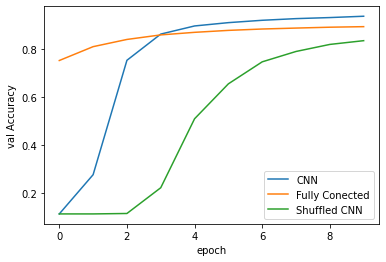

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results_with_pool, label='CNN')
sns.lineplot(x='epoch', y='val Accuracy', data=fc_results, label='Fully Conected')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results_with_pool_shuffle, label='Shuffled CNN')